In [1]:
import torchtext
from torchtext.vocab import Vectors, GloVe
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from submission.models import *
from evaluation import *
from submission.helpers import *

In [2]:
# Our input $x$
TEXT = torchtext.data.Field()
    
# Our labels $y$
LABEL = torchtext.data.Field(sequential=False)


train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

# Build vocab
TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
(train, val, test), batch_size=50, device=-1, repeat=False)

# Build the vocabulary with word embeddings
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

In [3]:
model_lr = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, model_lr)
trainer.train(train_iter, num_iter=1000, skip_iter=100)

AttributeError: 'LogisticRegression' object has no attribute 'do_binary'

In [ ]:
model = MultinomialNB(TEXT, LABEL)
model.train(train_iter)

In [22]:
model_eval(model_lr, test)

(1310, 1821)

Iteration 0, loss: 1.153387
Iteration 100, loss: 0.651786
Iteration 200, loss: 0.630142
Iteration 300, loss: 0.566883
Iteration 400, loss: 0.602412
Iteration 500, loss: 0.512245
Iteration 600, loss: 0.506338
Iteration 700, loss: 0.547287
Iteration 800, loss: 0.517960
Iteration 900, loss: 0.424601
Iteration 1000, loss: 0.488346
Iteration 1100, loss: 0.404376
Iteration 1200, loss: 0.420996
Iteration 1300, loss: 0.354671
Iteration 1400, loss: 0.367642
Iteration 1500, loss: 0.478275
Iteration 1600, loss: 0.231360
Iteration 1700, loss: 0.275645
Iteration 1800, loss: 0.333904
Iteration 1900, loss: 0.263724
Iteration 2000, loss: 0.316354
Iteration 2100, loss: 0.215668
Iteration 2200, loss: 0.342192
Iteration 2300, loss: 0.214530
Iteration 2400, loss: 0.157793
Iteration 2500, loss: 0.164580
Iteration 2600, loss: 0.155781
Iteration 2700, loss: 0.135578
Iteration 2800, loss: 0.130342
Iteration 2900, loss: 0.166151
Iteration 3000, loss: 0.074885
Iteration 3100, loss: 0.098157
Iteration 3200, loss

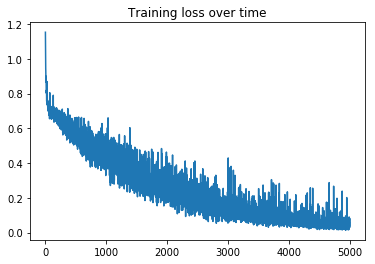

In [4]:
model = CNN(TEXT, LABEL, do_binary=False)
trainer = TextTrainer(TEXT, LABEL, model, optimizer=optim.Adadelta)
trainer.train(train_iter, num_iter=5000)

In [5]:
model.eval()
# evaluator = TextEvaluator(model)
# evaluator.score(test_iter)
print(model_eval(model, test, do_binary=False))

(1460, 1821)


In [25]:
def model_eval2(model, test, test_iter=None, do_binary=False):
    if test_iter is None:
        test_iter = torchtext.data.BucketIterator(test, train=False,
                                                  batch_size=10,
                                                  device=-1)
    cnt_correct = 0
    cnt_total = 0
    for batch in test_iter:
        classes = get_predictions(model, batch)
        cnt_total += batch.text.size()[1]
        # print(batch.label == argmax, (batch.label == argmax).sum().data[0])
        labels = TextTrainer.get_label(batch, do_binary)#.type(torch.LongTensor)
        cnt_correct += (classes.data == labels).sum()
    return (cnt_correct, cnt_total)

## Ignore stuff below here (aka should delete)

In [ ]:
class MultinomialNB2(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(MultinomialNB2, self).__init__()
        self._TEXT = TEXT
        self._LABEL = LABEL
        self._text_vocab_len = len(self._TEXT.vocab)        
        self.n_positive = 0
        self.n_negative = 0
        # Smoothing para is 1 for all features
        self.p = torch.ones(self._text_vocab_len)
        self.q = torch.ones(self._text_vocab_len)
        self.r = None
        self.index_pos = LABEL.vocab.itos.index('positive')
        self.index_neg = LABEL.vocab.itos.index('negative')

    # could use EmbeddingsBag, but there's not a huge difference in
    # performance
    def get_features(self, batch):
        size_batch = batch.size()[0]
        features = torch.zeros(size_batch, self._text_vocab_len)
        for i in range(size_batch):
            for j in batch[i, :]:
                features[i, j.data[0]] += 1
        return features
        # return torch.Tensor(features)

    def train(self, train_iter):
        # There's probably a better way to do this
        num_iter = len(train_iter)
        train_iter = iter(train_iter)
        for i in range(num_iter):
            batch = next(train_iter)
            if i % 100 == 0:
                print(i)
            # Should be [N, num-features]
            features = self.get_features(torch.t(batch.text).contiguous())

            # Using broadcasting
            inds_pos = torch.nonzero(batch.label.data == self.index_pos)
            inds_neg = torch.nonzero(batch.label.data == self.index_neg)


            if inds_pos.size():
                self.n_positive += inds_pos.size()[0]
                self.p = torch.add(self.p, torch.sum(features[inds_pos, :], dim=0))                
            if inds_neg.size():
                self.n_negative += inds_neg.size()[0]
                self.q = torch.add(self.q, torch.sum(features[inds_neg, :], dim=0))

            # print(features)
            # print(inds_neg, inds_pos)
            # print(self.p.size(), torch.sum(features, dim=0).size())

        self.r = torch.log((self.p / self.p.sum()) / (self.q / self.q.sum()))
        
    def forward(self, batch):
        # for k in range(batch_text.size()[1]):
        features = self.get_features(batch)
        # Using broadcasting
        return torch.matmul(features, torch.squeeze(self.r)) + \
            np.log(self.n_positive / self.n_negative)

In [ ]:
def model_eval2(model, test):
    test_iter = torchtext.data.BucketIterator(test, train=False, batch_size=10,
                                              device=-1)
    cnt_correct = 0
    cnt_total = 0
    for batch in test_iter:
        probs = model(torch.t(batch.text).contiguous())
        if len(probs.size()) == 1 or (len(probs.size()) == 2 \
                                      and probes.size()[1] == 1):
            signs = torch.sign(probs).type(torch.LongTensor)
            classes = (signs + 1) * (model.index_pos - model.index_neg) / 2 + \
                      model.index_neg
            # print(classes, probs)
        else:
            _, argmax = probs.max(1)
            classes = argmax
            
        cnt_total += batch.text.size()[1]
        # print(batch.label == argmax, (batch.label == argmax).sum().data[0])
        cnt_correct += (classes == batch.label.data).sum()
    return (cnt_correct, cnt_total)


In [ ]:
class CBOW(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(CBOW, self).__init__()
        # Embeddings vectors (should be trainable); [V, d]
        # TODO: is default for requires_grad True?
        self.embeddings = nn.EmbeddingBag(TEXT.vocab.vectors.size()[0],
                                          TEXT.vocab.vectors.size()[1],
                                          mode='sum')
        self.embeddings.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad=True)
        
        # Linear layer
        self.linear = nn.Linear(TEXT.vocab.vectors.size()[1], len(LABEL.vocab))
        
    # Here bow is [len-of-sentence, N] -- it is an integer matrix
    def forward(self, bow):
        bow_features = self.embeddings(bow)
        return F.log_softmax(self.linear(bow_features), dim=1)